In [1]:
import numpy as np
import cv2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from os import listdir

In [2]:
def preprocess_image(image_path):
    """Loads image from path and resizes it"""
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

#VGGFace modeli intarnetten bulup konumuza implement ediyoruz sadece weigtlerini indirdiğimiz için networkü tanımlamamız gerkiyorç
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))


#bu kısımı yazmaz isek resimlerdeki yüzler detect edilir fakat yazılar yazmaz.
from tensorflow.keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

model = vgg_face_descriptor

print("Model Loaded")

Model Loaded


In [3]:
#indirdiğimiz weightleri modelimize tanımlıyourzç
model.load_weights('vgg_face_weights.h5')

In [4]:
# videoyu frame frame izleyeceğimizden dolayı her frame de görüntü almak için imshow fonksiyonunu tanımlıyoruz.
def imshow(title = "Image", image = None, size = 8):
      w, h = image.shape[0], image.shape[1]
      aspect_ratio = w/h
      plt.figure(figsize=(size * aspect_ratio,size))
      plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      plt.title(title)
      plt.show()

Collected image names


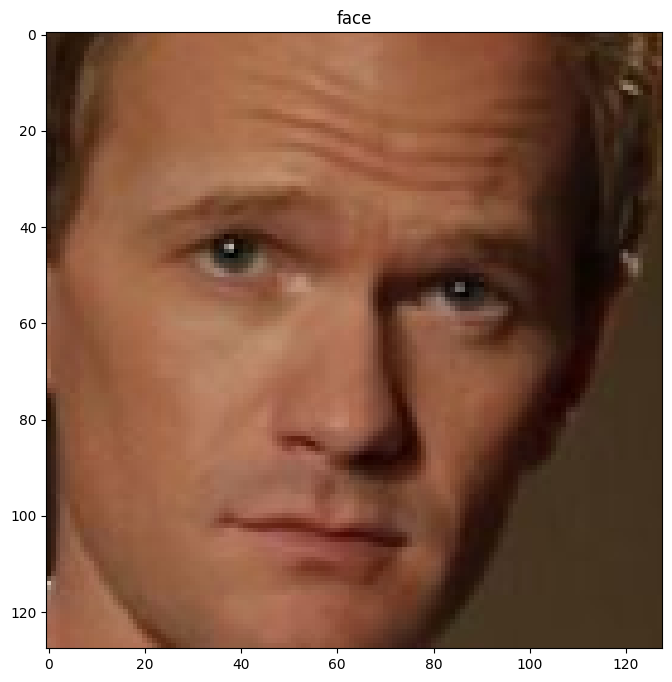

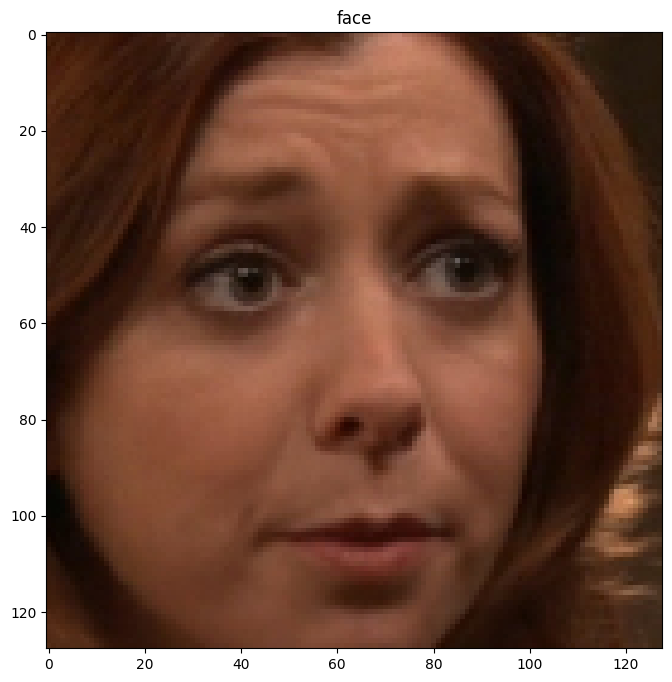

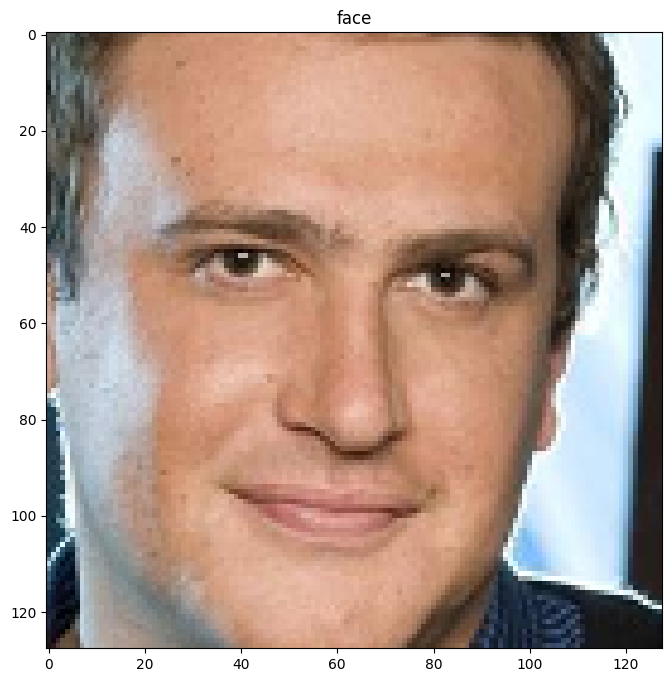

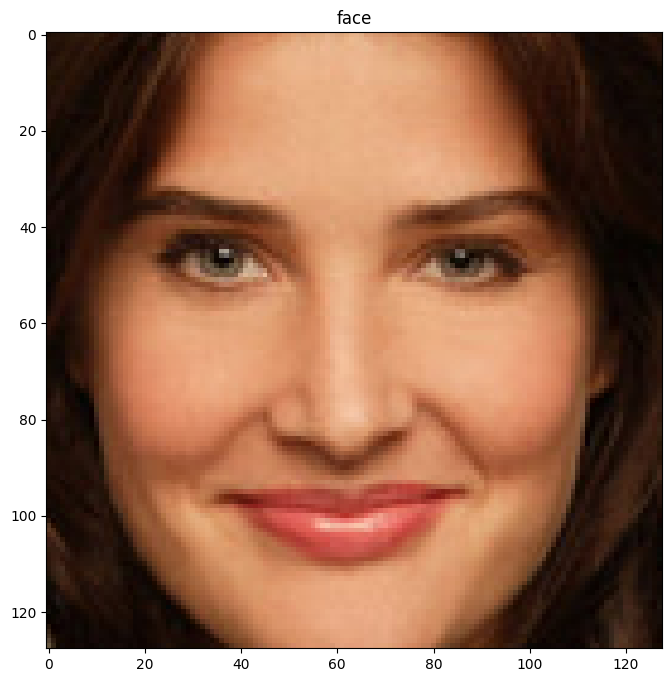

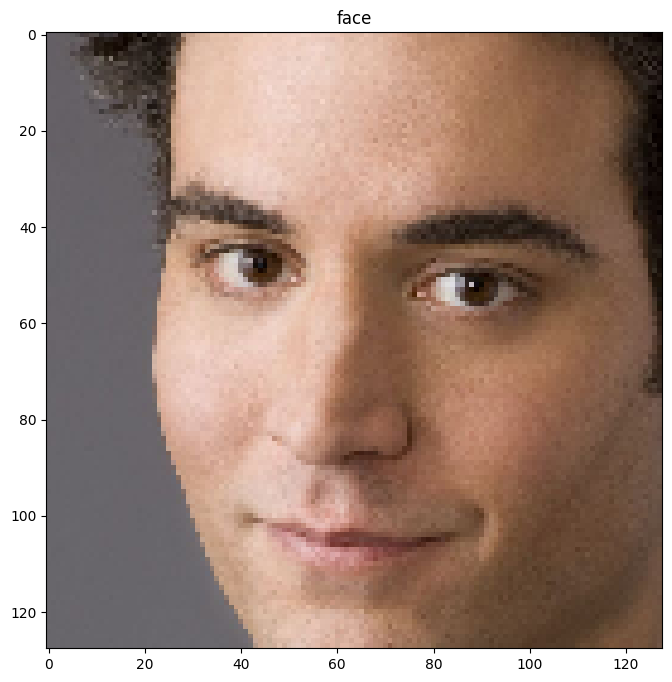

In [5]:
#bu bizim resimlerimizin sadece yüz kısımlarını almamızı sağlayan bloktur.
from os import listdir
from os.path import isfile, join
import cv2
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Yeni ürettiğimiz resimleri kaydetme fonksiyonu
def makedir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        return None
    else:
        pass

face_detector = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml') #haarcascade'i nereye indirdiysek path'ini vererek tanımlayalım.

mypath = "./peoples/" #bu kısıma istediğiniz insan fotoğflarını koayabilirsiniz bu kısımdaki fonsksiyon koyduğunuz fotoğraflardaki yüzleri alıcak
image_file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print("Collected image names")
makedir("./peoples_faces/") #alının yüzleri kaydetmek istediğiniz dosyanın adı.

for image_name in image_file_names:
    person_image = cv2.imread(mypath+image_name)
    face_info = face_detector.detectMultiScale(person_image, 1.3, 5)
    for (x,y,w,h) in face_info:
        face = person_image[y:y+h, x:x+w]
        roi = cv2.resize(face, (128, 128), interpolation = cv2.INTER_CUBIC)
    path = "peoples_faces/" + "face_" + image_name #indirilen yeni resimlere verilecek olan ad.
    cv2.imwrite(path, roi)
    imshow("face", roi)

In [6]:
#asıl önemli olan kısım belirleme kısımına geldik
people_pictures = "./peoples_faces/" #az önce küçülttüğümüz sadece yüz olan fotoğrafların pathini veriyoruz.

all_people_faces = dict()

for file in listdir(people_pictures):
    person_face, extension = file.split(".")
    try:
      all_people_faces[person_face] = model.predict(preprocess_image('./peoples_faces/%s.jpg' % (person_face)))[0,:]
    except:
      pass

print("Face representations retrieved successfully")

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

cap = cv2.VideoCapture('himyim.mp4')
frame_count = 0

# Get the height and width of the frame (required to be an integer)
w = int(cap.get(3)) + 200
h = int(cap.get(4)) + 200

# VideoWriter kullanarak oluşturğumuz videoyu kaydedip işlem bittirkten sonra izleyebiliriz.
out = cv2.VideoWriter('himyim-with-rec.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (w, h))

while(True):
  ret, img = cap.read()
  if ret:
    #img = cv2.resize(img, (320, 180)) # Re-size video to as smaller size to improve face detection speed
    img = cv2.copyMakeBorder(img, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=[0,0,0])
    faces = face_detector.detectMultiScale(img, 1.3, 5)
    frame_count+=1
    for (x,y,w,h) in faces:
      if w > 13:
          cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw rectangle to main image

          detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
          detected_face = cv2.resize(detected_face, (224, 224)) #resize to 224x224

          img_pixels = image.img_to_array(detected_face)
          ls = image.img_to_array(detected_face)
          img_pixels = np.expand_dims(img_pixels, axis = 0)
          img_pixels /= 255

          captured_representation = model.predict(img_pixels)[0,:] #tanımladığımız modeli kullanarak tahmin işlemini gerçekleştiriyoruz.

          found = 0
          for i in all_people_faces:
            person_name = i
            representation = all_people_faces[i]

            similarity = findCosineSimilarity(representation, captured_representation)
            print(similarity)
            if(similarity < 0.50):
                cv2.putText(img, person_name[5:], (int(x+w+15), int(y-12)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                found = 1
                break

            #connect face and text
            cv2.line(img,(int((x+x+w)/2),y+15),(x+w,y-20),(255, 0, 0),1)
            cv2.line(img,(x+w,y-20),(x+w+10,y-20),(255, 0, 0),1)
          if(found == 0): #if found image is not in our people database
            cv2.putText(img, 'unknown', (int(x+w+15), int(y-12)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    imshow('img',cv2.resize(img, (640, 640)))
    out.write(img)
  else:
    break

cap.release()
out.release()